In [ ]:
# Checkout www.pygimli.org for more examples


# Incorporating prior data into ERT inversion
Prior data can often help to overcome ambiguity in the inversion process.
Here we demonstrate the use of direct push (DP) data in an ERT inversion of
data collected at the surface.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg
from pygimli.physics import ert
from pygimli.frameworks import PriorModelling, JointModelling
from pygimli.viewer.mpl import draw1DColumn

## The prior data

This field data is from a site with layered sands and clays over a
resistive bedrock. We load it from the example repository.

As a position of x=155m (center of the profile) we have a
borehole/direct push with known in-situ-data. We load the three-column
file using numpy.




05/08/24 - 16:19:41 - pyGIMLi - INFO - Looking for ert/bedrock.txt in gimli-org/example-data/


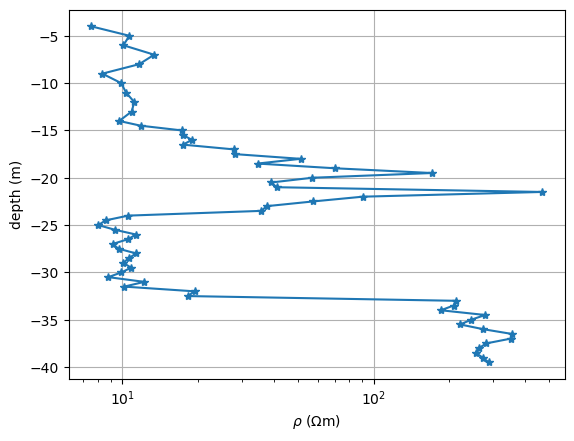

In [6]:
x, z, r = pg.getExampleData("ert/bedrock.txt").T
fig, ax = plt.subplots()
ax.semilogx(r, z, "*-")
ax.set_xlabel(r"$\rho$ ($\Omega$m)")
ax.set_ylabel("depth (m)")
ax.grid(True)

We mainly see four layers: 1. a conductive (clayey) overburden of about
17m thickness, 2. a medium resistivity interbedding of silt and sand,
about 7m thick 3. again clay with 8m thickness 4. the resistive bedrock
with a few hundred $\Omega$m




## The ERT data
We load the ERT data from the example repository and plot the pseudosection.




05/08/24 - 16:20:24 - pyGIMLi - INFO - Looking for ert/bedrock.dat in gimli-org/example-data/


Data: Sensors: 64 data: 1223, nonzero entries: ['a', 'b', 'err', 'm', 'n', 'rhoa', 'valid']


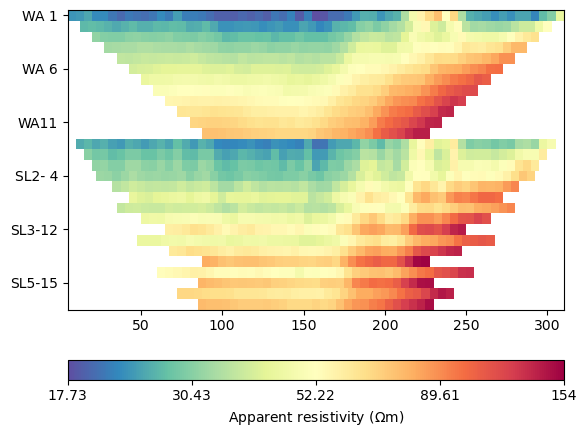

In [7]:
data = pg.getExampleData("ert/bedrock.dat")
print(data)
ax, cb = ert.show(data)

The apparent resistivities show increasing values with larger spacings
with no observable noise. We first compute geometric factors and
estimate an error model using rather low values for both error parts.




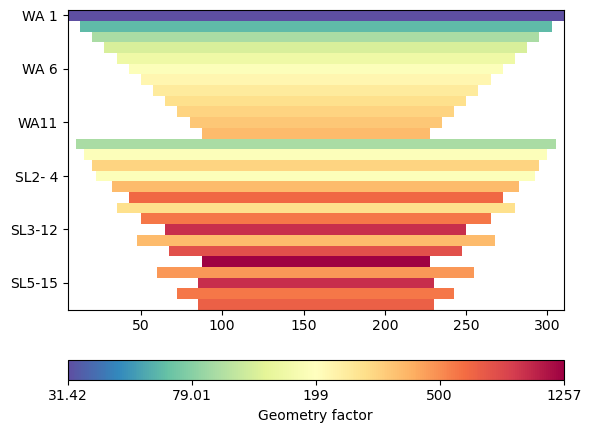

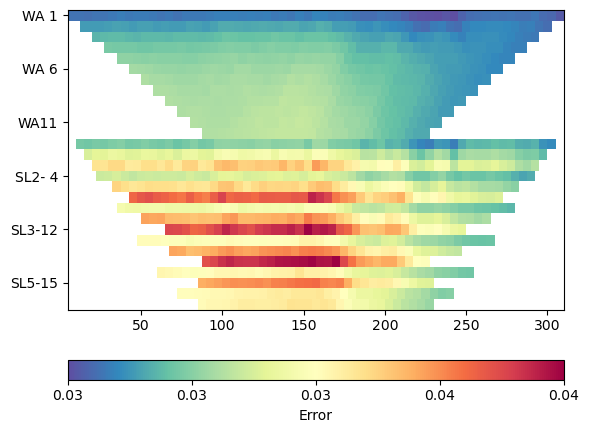

In [9]:
data.estimateError(relativeError=0.025, absoluteUError=100e-6)
# data["k"] = ert.geometricFactors(data)
# data["err"] = ert.estimateError(data, relativeError=0.025, absoluteUError=100e-6)
#print(data, data.tokenList())
ax, cb = ert.show(data, data["k"], logScale=True, label='Geometry factor')
ax, cb = ert.show(data, data["err"], label='Error')


We create an ERT manager and invert the data, already using a rather low value for
the vertical smoothness to account for the layered model.




In [10]:
mgr = ert.ERTManager(data, verbose=True)
mgr.invert(paraDepth=70, quality=34.2, paraMaxCellSize=1000, zWeight=0.15, lam=30)

05/08/24 - 17:13:18 - pyGIMLi - INFO - Found 2 regions.
05/08/24 - 17:13:18 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
05/08/24 - 17:13:18 - pyGIMLi - INFO - Found 2 regions.
05/08/24 - 17:13:18 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
05/08/24 - 17:13:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
05/08/24 - 17:13:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
05/08/24 - 17:13:18 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 4592 Cells: 8820 Boundaries: 6796
05/08/24 - 17:13:18 - pyGIMLi - INFO - Use median(data values)=48.34
05/08/24 - 17:13:18 - pyGIMLi - INFO - Created startmodel from forward operator: 1574, min/max=48.340000/48.340000
05/08/24 - 17:13:18 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001E5778BFC90>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001E57787BF60>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001E57731E9D0>
min/max (data): 17.73/154
min/max (error): 2.54%/4.38%
min/max (start model): 48.34/48.34
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  241.67
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    4.54 (dPhi = 97.98%) lam: 30.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    4.30 (dPhi = 5.11%) lam: 30.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    4.09 (dPhi = 4.86%) lam: 30.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    3.51 (dPhi = 14.30%) l

1574 [32.4595191668608,...,194.36731861654195]

For reasons of comparability, we define a unique colormap and store all
options in a dictionary to be used in subsequent show commands.

We plot the result with these and plot the DP points onto the mesh.




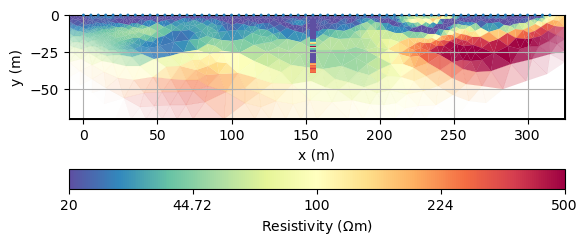

In [12]:
kw = dict(cMin=20, cMax=500, logScale=True, cMap="Spectral_r",
          xlabel="x (m)", ylabel="y (m)")
ax, cb = mgr.showResult(**kw)
zz = np.abs(z)
iz = np.argsort(z)
dz = np.diff(zz[iz])
thk = np.hstack([dz, dz[-1]])
ztop = -zz[iz[0]]-dz[0]/2
colkw = dict(x=x[0], val=r[iz], thk=thk, width=4, ztopo=ztop)
draw1DColumn(ax, **colkw, **kw)
ax.grid(True)

We want to extract the resistivity from the mesh at the positions where
the prior data are available. To this end, we create a list of positions
(``pg.Pos`` class) and use a forward operator that picks the values from a
model vector according to the cell where the position is in. See the
regularization tutorial for details about that.




In [13]:
posVec = [pg.Pos(pos) for pos in zip(x, z)]
para = pg.Mesh(mgr.paraDomain)  # make a copy
para.setCellMarkers(pg.IVector(para.cellCount()))
fopDP = PriorModelling(para, posVec)

05/08/24 - 17:23:26 - pyGIMLi - INFO - Found 1 regions.


We can now use it to retrieve the model values, store it and plot it along
with the measured values.




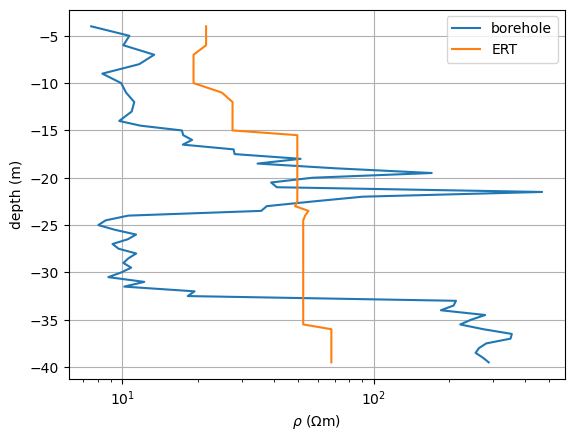

In [14]:
fig, ax = plt.subplots()
ax.semilogx(r, z, label="borehole")
resSmooth = fopDP(mgr.model)
ax.semilogx(resSmooth, z, label="ERT")
ax.set_xlabel(r"$\rho$ ($\Omega$m)")
ax.set_ylabel("depth (m)")
ax.grid(True)
ax.legend()

As alternative to smoothness, we can use a geostatistic model. The vertical
range can be well estimated from the DP data using a variogram analysis, we
guess 8m. For the horizontal one, we can only guess a ten times higher value.




05/08/24 - 17:28:14 - pyGIMLi - INFO - Use median(data values)=48.34
05/08/24 - 17:28:14 - pyGIMLi - INFO - Created startmodel from forward operator: 1574, min/max=48.340000/48.340000
05/08/24 - 17:28:14 - pyGIMLi - INFO - Starting inversion.
05/08/24 - 17:28:15 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 2 with: I=[40, 4], dip=0, strike=0


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001E5778BFC90>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001E57787BF60>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001E5C1CC5E00>
min/max (data): 17.73/154
min/max (error): 2.54%/4.38%
min/max (start model): 48.34/48.34
--------------------------------------------------------------------------------


05/08/24 - 17:28:17 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 2.5s
05/08/24 - 17:28:17 - pyGIMLi - INFO - Cache stored: C:\Users\matthew.noteboom\AppData\Roaming\pygimli\Cache\7523890123514115738


inv.iter 0 ... chi² =  241.67
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   36.25 (dPhi = 84.89%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    8.54 (dPhi = 76.27%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    0.36 (dPhi = 94.46%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.36)                   #
################################################################################


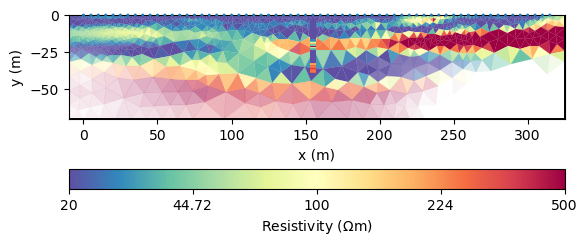

In [15]:
mgr.inv.setRegularization(2, correlationLengths=[40, 4])
mgr.invert()
ax, cb = mgr.showResult(**kw)
draw1DColumn(ax, **colkw, **kw)
resGeo = fopDP(mgr.model)

Let's compare the three resistivity soundings with the ground truth.




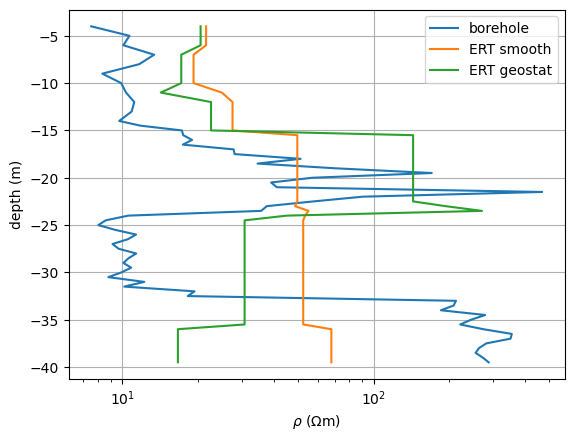

In [20]:
fig, ax = plt.subplots()
ax.semilogx(r, z, label="borehole")
ax.semilogx(resSmooth, z, label="ERT smooth")
#ax.semilogx(res2, z, label="ERT aniso")
ax.semilogx(resGeo, z, label="ERT geostat")
ax.set_xlabel(r"$\rho$ ($\Omega$m)")
ax.set_ylabel("depth (m)")
ax.grid()
ax.legend()

The anisotropic regularization starts to see the good conductor, but only
the geostatistical regularization operator is able to retrieve values that
are close to the direct push. Both show the conductor too deep.

One alternative could be to use the interfaces as structural constraints in
the neighborhood of the borehole. See ERT with structural constraints example

As the DP data is not only good for comparison, we want to use its values as
data in inversion. This is easily accomplished by taking the mapping operator
that we already use for interpolation as a forward operator.

We set up an inversion with this mesh, logarithmic transformations and
invert the model.




05/08/24 - 17:36:51 - pyGIMLi - INFO - Use median(data values)=17.84227805
05/08/24 - 17:36:51 - pyGIMLi - INFO - Created startmodel from forward operator: 1574, min/max=17.842278/17.842278
05/08/24 - 17:36:51 - pyGIMLi - INFO - Starting inversion.
05/08/24 - 17:36:51 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 0 with: I=[40, 4], dip=0, strike=0
05/08/24 - 17:36:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
05/08/24 - 17:36:52 - pyGIMLi - INFO - Cache C:\Users\matthew.noteboom\.conda\envs\pg\Lib\site-packages\pygimli\math\matrix.py:createCm05 restored (2.5s x 1): C:\Users\matthew.noteboom\AppData\Roaming\pygimli\Cache\7523890123514115738


fop: <pygimli.frameworks.modelling.PriorModelling object at 0x000001E577333830>
Data transformation: <pgcore._pygimli_.RTransLog object at 0x000001E577A11030>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001E5C1D5F060>
min/max (data): 7.52/469
min/max (error): 20%/20%
min/max (start model): 17.84/17.84
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   55.40
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   21.59 (dPhi = 59.94%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   21.59 (dPhi = 0.46%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   21.59 (dPhi = 0.18%) lam: 20.0
################################################################################
#                Abort criterion reached: dPhi = 0.18 (<

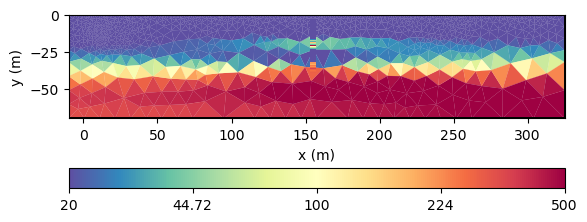

In [21]:
inv = pg.Inversion(fop=fopDP, verbose=True)
inv.mesh = para
tLog = pg.trans.TransLog()
inv.modelTrans = tLog
inv.dataTrans = tLog
inv.setRegularization(correlationLengths=[40, 4])
model = inv.run(r, relativeError=0.2)
ax, cb = pg.show(para, model, **kw)
draw1DColumn(ax, **colkw, **kw)

Apparently, the geostatistical operator can be used to extrapolate
values with given assumptions.




## Joint inversion of ERT and DP data

We now use the framework ``JointModelling`` to combine the ERT and the
DP forward operators. So we set up a new ERT modelling operator and join
it with ``fopDP``.




In [14]:
# fopERT = ert.ERTModelling()
# fopERT.setMesh(mesh)
# fopERT.setData(data) # not necessary as done by JointModelling
# fopJoint = JointModelling([fopERT, fopDP])
fopJoint = JointModelling([mgr.fop, fopDP])
# fopJoint.setMesh(para)
fopJoint.setData([data, pg.Vector(r)])  # needs to have .size() attribute!

We first test the joint forward operator. We create a modelling vector
of constant resistivity and distribute the model response into the two
parts that can be looked at individually.




In [15]:
model = pg.Vector(para.cellCount(), 100)
response = fopJoint(model)
respERT = response[:data.size()]
respDP = response[data.size():]
print(respDP)

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


The jacobian can be created and looked up by




<class 'pgcore._pygimli_.RBlockMatrix'>
RMatrix: 1223 x 1574


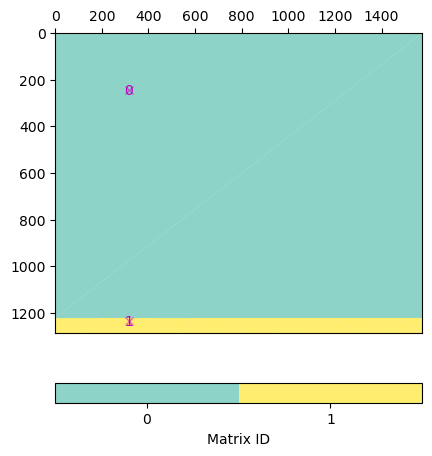

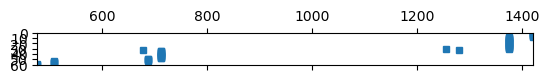

In [16]:
fopJoint.createJacobian(model)  # works
J = fopJoint.jacobian()
print(type(J))  # wrong type
ax, cb = pg.show(J)
print(J.mat(0))
ax, cb = pg.show(J.mat(1), markersize=4)

For the joint inversion, concatenate the data and error vectors, create a new
inversion instance, set logarithmic transformations and run the inversion.




24/07/24 - 15:27:45 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.modelling.JointModelling object at 0x000001AEC9DA7740>
Data transformation: <pgcore._pygimli_.RTransLog object at 0x000001AEC9E29030>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001AEB37BAA40>
min/max (data): 7.52/469
min/max (error): 2.54%/20%
min/max (start model): 100/100
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  788.14
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    5.35 (dPhi = 99.29%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    4.39 (dPhi = 17.79%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    3.47 (dPhi = 20.67%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.36 (dPhi = 57.76%) lam: 20.0


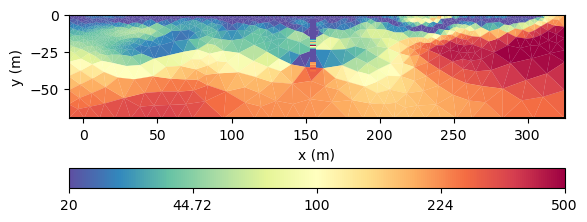

In [17]:
dataVec = np.concatenate((data["rhoa"], r))
errorVec = np.concatenate((data["err"], np.ones_like(r)*0.2))
inv = pg.Inversion(fop=fopJoint, verbose=True)
transLog = pg.trans.TransLog()
inv.modelTrans = transLog
inv.dataTrans = transLog
inv.run(dataVec, errorVec, startModel=model)
ax, cb = pg.show(para, inv.model, **kw)
draw1DColumn(ax, **colkw, **kw)

We have a local improvement of the model in the neighborhood of the
borehole. Now we want to use geostatistics to get them further into the
model.




24/07/24 - 15:28:16 - pyGIMLi - INFO - Starting inversion.
24/07/24 - 15:28:17 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 2 with: I=[40, 4], dip=0, strike=0
24/07/24 - 15:28:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/07/24 - 15:28:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/07/24 - 15:28:17 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 4592 Cells: 8820 Boundaries: 6796


fop: <pygimli.frameworks.modelling.JointModelling object at 0x000001AEC9DA7740>
Data transformation: <pgcore._pygimli_.RTransLog object at 0x000001AEC9E29030>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001AEC9E25380>
min/max (data): 7.52/469
min/max (error): 2.54%/20%
min/max (start model): 100/100
--------------------------------------------------------------------------------


24/07/24 - 15:28:17 - pyGIMLi - INFO - Cache C:\Users\matthew.noteboom\.conda\envs\pg\lib\site-packages\pygimli\math\matrix.py:createCm05 restored (2.5s x 2): C:\Users\matthew.noteboom\AppData\Roaming\pygimli\Cache\632179970329579328


inv.iter 0 ... chi² =  788.14
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   12.54 (dPhi = 98.38%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.16 (dPhi = 50.60%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.54 (dPhi = 57.41%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.82 (dPhi = 26.97%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² =    1.21 (dPhi = 31.03%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 6 ... chi² =    1.21 (dPhi = 0.19%) lam: 20.0
################################################################################
#                Abort criterion reached: dPhi = 0.19 (< 2.0%)      

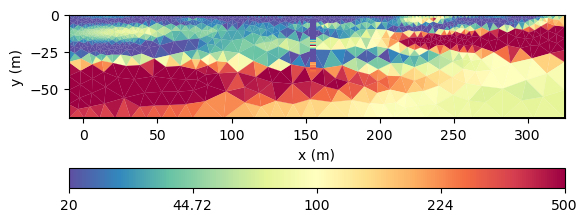

In [18]:
inv.setRegularization(2, correlationLengths=[40, 4])
model = inv.run(dataVec, errorVec, startModel=model)
ax, cb = pg.show(para, model, **kw)
draw1DColumn(ax, **colkw, **kw)

This model much better resembles the subsurface from all data and our
expectations to it.

We split the model response in the ERT part and the DP part. The first
is shown as misfit.




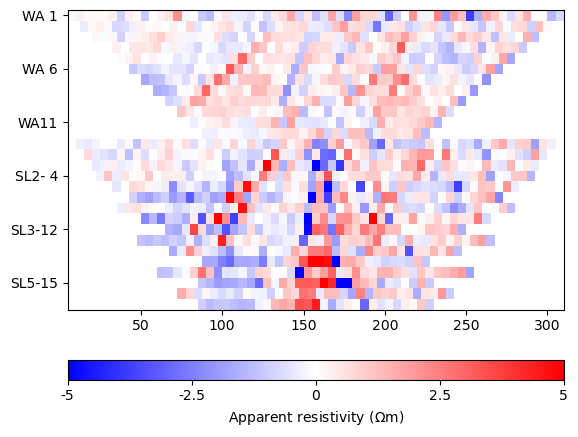

In [20]:
respERT = inv.response[:data.size()]
misfit = - respERT / data["rhoa"] * 100 + 100
ax, cb = ert.show(data, misfit, cMap="bwr", cMin=-5, cMax=5)

The second is shown as depth profile.




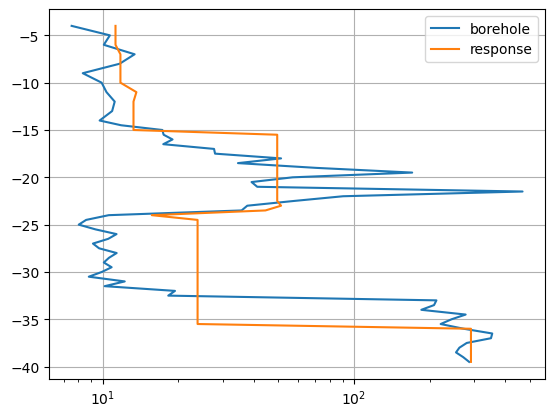

In [21]:
respDP = inv.response[data.size():]
fig, ax = plt.subplots()
ax.semilogx(r, z, label="borehole")
# resMesh = pg.interpolate(srcMesh=para, inVec=inv.model, destPos=posVec)
# ax.semilogx(resMesh, z, label="ERT+DP")
ax.semilogx(respDP, z, label="response")
ax.grid(True)
ax.legend()

The model response can much better resemble the given data compared to
pure interpolation. However, at shallow depth there is some inconsistency between
the ERT data and the borehole data.




<div class="alert alert-info"><h4>Note</h4><p>Take-away messages

   -  (ERT) data inversion is highly ambiguous, particularly for hidden layers
   -  prior data can help to improve regularization
   -  point data improve images, but only locally with smoothness constraints
   -  geostatistical regularization can extrapolate point data
   -  incorporation of prior data with geostatistic regularization is best</p></div>


